In [1]:

### Required libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from subprocess import check_output
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import bernoulli
import seaborn as sns

In [3]:
train_path1='train_jpg'
test_path1='train_jpg'

                                                 label  count
2                                        clear primary  13636
11                               partly_cloudy primary   3630
10                                              cloudy   2089
9                                  clear primary water   1850
12                      agriculture clear primary road   1680
18                           agriculture clear primary   1626
0                                         haze primary   1471
6                agriculture clear cultivation primary   1170
3            agriculture clear habitation primary road   1125
1                      agriculture clear primary water    712
34                   agriculture partly_cloudy primary    692
30                         partly_cloudy primary water    595
26              agriculture partly_cloudy primary road    527
13                            clear primary road water    504
16                           clear cultivation primary    472
27      

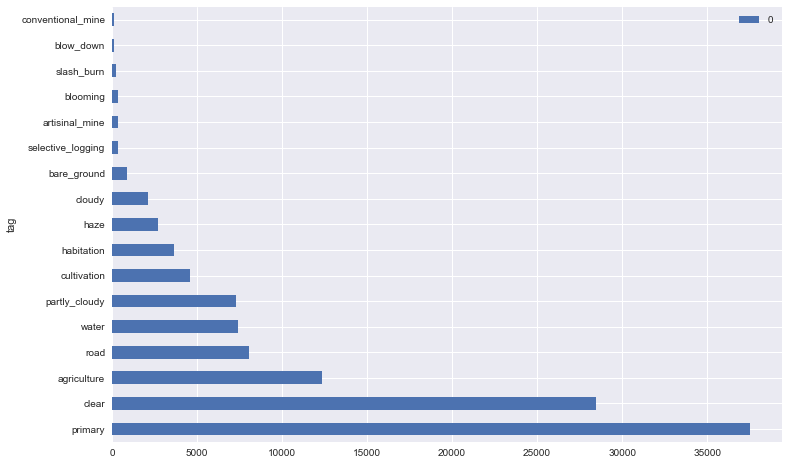

In [21]:
df = pd.read_csv('train_labels.csv')

all_tags = [item for sublist in list(df['tags'].apply(lambda row: row.split(" ")).values) for item in sublist]
# print(all_tags)
# example data
from collections import Counter

counts = Counter(df['tags'])
df_counts = pd.DataFrame.from_dict(counts, orient='index').reset_index()
df_counts = df_counts.rename(columns={'index':'label', 0:'count'})


print(df_counts.sort_values(by=['count'], ascending=False))
print(df_counts[df_counts ['count']< 5.0 ].count())


print('total of {} non-unique tags in all training images'.format(len(all_tags)))
print('average number of labels per image {}'.format(1.0*len(all_tags)/df.shape[0]))

tags_counted_and_sorted = pd.DataFrame({'tag': all_tags}).groupby('tag').size().reset_index().sort_values(0, ascending=False)
tags_counted_and_sorted.head()
tags_counted_and_sorted.plot.barh(x='tag', y=0, figsize=(12,8))

In [14]:

image_paths = sorted(os.listdir(path1))[0:1000]

image_names = list(map(lambda row: row.split("/")[-1][:-4], image_paths))
image_names[0:10]

['train_0',
 'train_1',
 'train_10',
 'train_100',
 'train_1000',
 'train_10000',
 'train_10001',
 'train_10002',
 'train_10003',
 'train_10004']

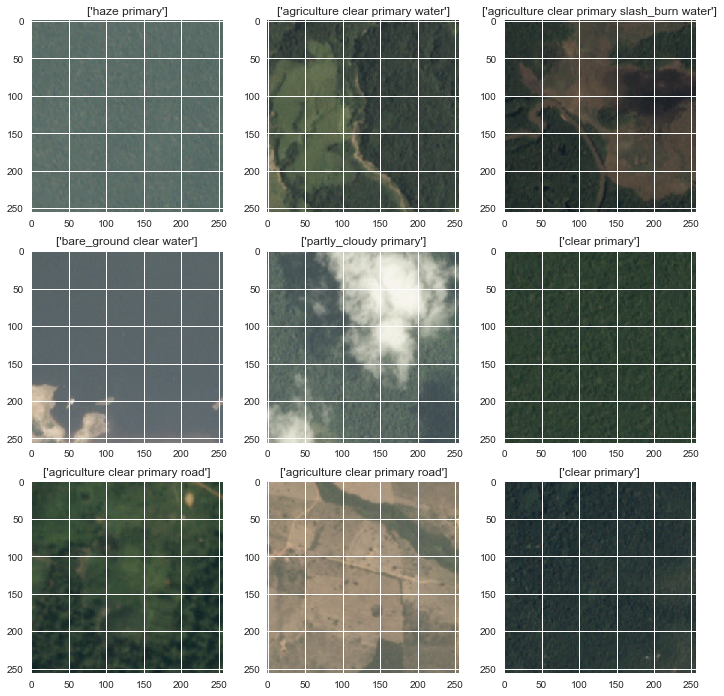

In [15]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3,3,i+1)
    path2='train_jp/'
    plt.imshow(plt.imread(path2+str(image_paths[i])))
    plt.title(str(df[df.image_name == image_names[i]].tags.values))

In [47]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
import cv2
import warnings

n_samples = 5000
rescaled_dim = 20

df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df['split_tags'])
y = y[:n_samples]
X = np.squeeze(np.array([cv2.resize(plt.imread(path1+'/{}.jpg'.format(name)), (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) for name in df.head(n_samples)['image_name'].values]))
X = MinMaxScaler().fit_transform(X)



C:\Users\Elle\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [19]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler
from sklearn.metrics import fbeta_score, precision_score, make_scorer, average_precision_score
import cv2
import warnings
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer


n_samples = 5000
rescaled_dim = 20

df['split_tags'] = df['tags'].map(lambda row: row.split(" "))
lb = MultiLabelBinarizer()
y = lb.fit_transform(df['split_tags'])
y = y[:n_samples]
X = np.squeeze(np.array([cv2.resize(plt.imread(path1+'/{}.jpg'.format(name)), (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) for name in df.head(n_samples)['image_name'].values]))
X = MinMaxScaler().fit_transform(X)

print(X.shape, y.shape, lb.classes_)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

(5000, 1600) (5000, 17) ['agriculture' 'artisinal_mine' 'bare_ground' 'blooming' 'blow_down'
 'clear' 'cloudy' 'conventional_mine' 'cultivation' 'habitation' 'haze'
 'partly_cloudy' 'primary' 'road' 'selective_logging' 'slash_burn' 'water']


C:\Users\Elle\Anaconda3\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype uint8 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [30]:
classifier = OneVsRestClassifier(LogisticRegression(C=1, penalty='l2'))

classifier.fit(X_train, y_train)
predicted = classifier.predict(X_test)
all_labels = lb.inverse_transform(predicted)

all_test_tags = []
for index in range(predicted.shape[0]):
    all_test_tags.append(' '.join(list(lb.classes_[np.where(predicted[index, :] == 1)[0]])))

In [31]:
print(all_test_tags[1:20])
print(y[1:20])

['primary', 'clear primary', 'clear primary', 'clear primary', 'clear primary', 'primary', 'partly_cloudy primary', 'clear primary', 'cloudy haze partly_cloudy', 'primary road', 'clear primary', 'primary', 'clear primary', 'agriculture clear primary', 'clear primary', 'primary road', 'clear primary', 'primary', 'clear primary']
[[1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1]
 [1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0]
 [1 0 0 0 0 1 0 0 1 0 0 0 1 1 0 0 0]
 [1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0]
 [1 

In [28]:
X_sub = np.squeeze(np.array([cv2.resize(plt.imread('../input/test-jpg-v2/{}.jpg'.format(name)), (rescaled_dim, rescaled_dim), cv2.INTER_LINEAR).reshape(1, -1) for name in sample['image_name'].values]))
X_sub = MinMaxScaler().fit_transform(X_sub)
X_sub.shape

NameError: name 'sample' is not defined